In [29]:
from typing import Annotated
from dotenv import load_dotenv
load_dotenv()

from typing_extensions import TypedDict, Literal
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage

In [30]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_task: str

def detect_task(state: State) -> State:
    user_input = state["messages"][-1].content
    prompt = """
    You are an task identifier
    Classify the request of user_input in to one of the following tasks:
    - summarize
    - study plan
    - Question & Answers
    - quiz

    Request: {user_input}
    """
    response = llm.invoke(prompt)
    user_task = response.content.strip().lower()
    if "summarize" in user_task:
        user_task = "summarize"
    elif "plan" in user_task:
        user_task = "study_plan"
    elif "question" in user_task or "answer" in user_task or "q&a" in user_task:
        user_task = "question&answer"
    elif "quiz" in user_task:
        user_task = "quiz"
    else:
        user_task = "question&answer"
    return {**state, "user_task": user_task}


In [31]:
def summarize(state: State) -> State:
    text = state["messages"][-1].content
    response = llm.invoke(f"Summarize this text for Study: {text}")
    return {**state, "messages": state["messages"] + [response]}

def study_plan(state: State) -> State:
    topic = state["messages"][-1].content
    response = llm.invoke(f"Create a weekly plan on {topic}")
    return {**state, "messages": state["messages"] + [response]}

def q_a(state: State) -> State:
    query = state["messages"][-1].content
    response = llm.invoke(query)
    return {**state, "messages": state["messages"] + [response]}

def quiz(state: State) -> State:
    topic = state["messages"][-1].content
    response = llm.invoke(f"Create a quiz with 5 questions on {topic}")
    return {**state, "messages": state["messages"] + [response]}

In [32]:
builder = StateGraph(State)
builder.add_node("detectTask_node", detect_task)
builder.add_node("summarize_node", summarize)
builder.add_node("studyPlan_node", study_plan)
builder.add_node("Q&A_node", q_a)
builder.add_node("quiz_node", quiz)

builder.add_edge(START, "detectTask_node")

builder.add_conditional_edges(
    "detectTask_node",
    lambda state: state["user_task"],
    {
        "summarize": "summarize_node",
        "study_plan": "studyPlan_node",
        "question&answer": "Q&A_node",
        "quiz": "quiz_node",
    }
)

builder.add_edge("summarize_node", END)
builder.add_edge("studyPlan_node", END)
builder.add_edge("Q&A_node", END)
builder.add_edge("quiz_node", END)

graph = builder.compile()

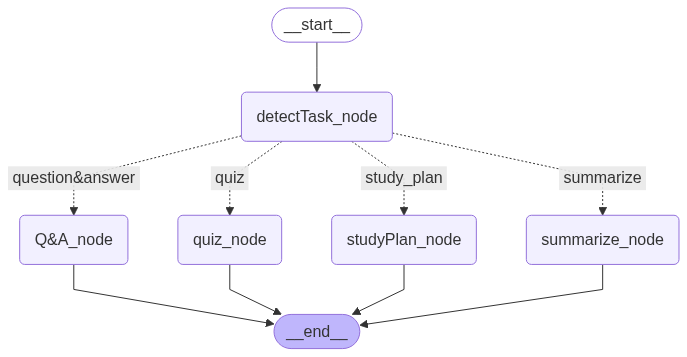

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
state = None
while True:
    in_message = input("You: ")
    if in_message.lower() in {"quit","exit"}:
        print("GoodBye")
        break
    if state is None:
        state: State = {
            "messages": [{"role": "user", "content": in_message}]
        }
    else:
        state["messages"].append({"role": "user", "content": in_message})

    state = graph.invoke(state)
    print("Bot:", state["messages"][-1].content)

Bot: LangGraph is a framework built on top of LangChain that allows you to create **stateful, multi-actor applications using graphs**. Think of it as a way to orchestrate complex conversational flows with multiple agents or functions working together in a structured, defined manner.

Here's a breakdown of the key aspects:

*   **Stateful:** LangGraph manages the state of your application throughout the conversation. This means it remembers previous interactions and uses that information to guide future actions.

*   **Multi-Actor:**  It enables you to incorporate multiple actors (like LLMs, tools, functions, or even human input) into your application. Each actor can perform a specific task.

*   **Graphs:**  The core of LangGraph is its use of a graph structure to define the flow of your application.  Nodes in the graph represent actors or steps, and edges represent the transitions between them. This provides a clear and visual way to understand and manage complex conversational flows.